In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time
import pandas as pd


In [2]:
# Define dimension, pauli matrices
sx = 1/np.sqrt(2) * np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=complex)
sy = -1j/np.sqrt(2) * np.array([[0, 1, 0], [-1, 0, 1], [0, -1, 0]], dtype=complex)
sz = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=complex)
I3 = np.eye(3, dtype=complex)
I2 = np.eye(2, dtype=complex)

# Rotation matrix projected into 2 level system
Sxp = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex)
Sxm = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex)

Syp = -1j * np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]], dtype=complex)
Sym = -1j * np.array([[0, 0, 0], [0, 0, 1], [0, -1, 0]], dtype=complex)

# Pauli basis for 13C nuclear spin
Ix = 1/2 * np.array([[0, 1], [1, 0]], dtype=complex)
Iy = 1/2 * -1j * np.array([[0,1], [-1,0]], dtype=complex)
Iz = 1/2 * np.array([[1, 0],  [0,-1]], dtype=complex)


def UO(B1, B2, a, D1, D2):
    """
    Generate NV spin gate function
    
    Parameters:
    -----------
    B1 : float
        Drive amplitude for |0⟩↔|+1⟩ transition
    B2 : float
        Drive amplitude for |0⟩↔|-1⟩ transition
    a : float
        Rotation angle
    D1, D2 : float
        Microwave phases
    
    Returns:
    --------
    U : ndarray (3x3)
        Rotation matrix for NV spin-1 system
    """
    Omega_sq = B1**2 + B2**2
    
    if Omega_sq == 0:
        return np.eye(3, dtype=complex)
    
    Omega = np.sqrt(Omega_sq)
    
    U = np.array([
        [(B2**2 + B1**2*np.cos(a))/Omega_sq, 
         -1j*B1*np.exp(-1j*D1)*np.sin(a)/Omega, 
         ((-1+np.cos(a))*B1*B2*np.exp(-1j*(D1-D2)))/Omega_sq],
        
        [-1j*B1*np.exp(1j*D1)*np.sin(a)/Omega, 
         np.cos(a), 
         -1j*B2*np.exp(1j*D2)*np.sin(a)/Omega],
        
        [((-1+np.cos(a))*B1*B2*np.exp(1j*(D1-D2)))/Omega_sq, 
         -1j*B2*np.exp(-1j*D2)*np.sin(a)/Omega, 
         (B1**2 + B2**2*np.cos(a))/Omega_sq]
    ], dtype=complex)
    
    return U

In [3]:
def NU0(Al, Ap, tau, Ng, B=448.4):
    """
    Generate nuclear spin gate function using dynamical decoupling
    
    Parameters:
    -----------
    Al : float
        Parallel hyperfine coupling (MHz)
    Ap : float
        Perpendicular hyperfine coupling (MHz)
    tau : float
        Evolution time (us)
    Ng : int
        Number of pi pulses
    B : float
        Magnetic field (G)
    
    Returns:
    --------
    NU : ndarray (9x9)
        Nuclear spin gate operator
    """
    # Define operators (local scope)
    
    sz_local = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=complex)
    I_local = np.eye(3, dtype=complex)
    Ix_local = 1/2 * np.array([[0, 1], [1, 0]], dtype=complex)
    Iz_local = 1/2 * np.array([[1, 0], [0, -1]], dtype=complex)
    
    # Single Q gates
    U180xp = UO(1, 0, np.pi/2, 0, 0)
    
    gammaN = 2*np.pi*1.071e-3  # MHz/G
    NU = np.kron(I_local, I_local)
    
    # Hamiltonian
    ham = (Al*np.kron(sz_local, Iz_local) + 
           Ap*np.kron(sz_local, Ix_local) + 
           B*gammaN*np.kron(I_local, Iz_local))
    
    # Diagonalize Hamiltonian
    eigvals, eigvecs = np.linalg.eig(ham)
    E = np.diag(eigvals)
    U_H = eigvecs.T.conj()
    
    # Free evolution operators
    U_e = eigvecs @ expm(-1j*E*tau) @ U_H
    U_e2 = eigvecs @ expm(-1j*E*tau/2) @ U_H
    
    # Build sequence
    NU = U_e2 @ NU
    
    for h in range(Ng-1):
        NU = U_e @ np.kron(U180xp, I_local) @ NU
    
    NU = U_e2 @ np.kron(U180xp, I_local) @ NU
    
    return NU


In [4]:
def PartialTrace(rho, system):
    """
    Compute partial trace over specified system
    
    Parameters:
    -----------
    rho : ndarray (9x9)
        Density matrix of composite system
    system : int
        Which system to trace out (1=first, 2=second)
    
    Returns:
    --------
    rho_reduced : ndarray (3x3)
        Reduced density matrix
    """
    if system == 1:
        # Trace out first system (NV spin)
        rho_reduced = np.zeros((2, 2), dtype=complex)
        for i in range(3):
            temp = np.zeros(3, dtype=complex).reshape(3, 1)
            temp[i] = 1
            rho_reduced += np.kron(temp.T, I2) @ rho @ np.kron(temp, I2)
    elif system == 2:
        # Trace out second system (nuclear spin)
        rho_reduced = np.zeros((3, 3), dtype=complex)
        for i in range(2):
            temp = np.zeros(2, dtype=complex).reshape(2, 1)
            temp[i] = 1
            rho_reduced += np.kron(I3, temp.T) @ rho @ np.kron(I3, temp)
    else:
        raise ValueError("system must be 1 or 2")
    
    return rho_reduced


In [9]:
# Define sweep parameters
Sweep = 5001
N = Sweep
B = 440.1  # Magnetic field [G]

# 13C nuclear spin parameters
gammaN = 2*np.pi*1.0705e-3  # MHz/G
Al = 2*np.pi*(-0.073)  # MHz, A_|| hyperfine term
Ap = 2*np.pi*0.042  # MHz, A_perp hyperfine term


T = 28  # sweep tau [us]
t = np.linspace(0, T, N)
n = 16  # number of pi pulses

# Define gate operations
# Single Q ms=+1
U090xp = UO(1, 0, np.pi/4, 0, 0)
U090xmp = UO(1, 0, -np.pi/4, 0, 0)
U090yp = UO(1, 0, np.pi/4, np.pi/2, 0)
U090ymp = UO(1, 0, -np.pi/4, np.pi/2, 0)
U180xp = UO(1, 0, np.pi/2, 0, 0)
U180xmp = UO(1, 0, -np.pi/2, 0, 0)
U180yp = UO(1, 0, np.pi/4, np.pi/2, 0)
U180ymp = UO(1, 0, -np.pi/4, np.pi/2, 0)

# Single Q ms=-1
U090xm = UO(0, 1, np.pi/4, 0, 0)
U090xmm = UO(0, 1, -np.pi/4, 0, 0)
U180xm = UO(0, 1, np.pi/2, 0, 0)
U180xmm = UO(0, 1, -np.pi/2, 0, 0)

# Define initial states
irho_p = np.array([[1, 0], [0, 0]], dtype=complex)
irho_m = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]], dtype=complex)
irho_z = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=complex)
irho_mix = np.array([[1/2, 0, 0], [0, 1/2, 0], [0, 0, 0]], dtype=complex)
irho_Z = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]], dtype=complex)
irho_MIX = np.array([[1/2, 0], [0, 1/2]], dtype=complex)


In [10]:
# Initial combined state
irho = np.kron(irho_z, irho_p)

# Initialization
rho_0 = np.kron(U090xm, I2) @ irho @ np.kron(U090xm, I2).T.conj()


In [11]:
print("Starting CPMG sweep simulation...")

# Main CPMG simulation loop
Sa = np.zeros(N)
ham = (Al*np.kron(sz, Iz) + 
        Ap*np.kron(sz, Ix) + 
        B*gammaN*np.kron(I3, Iz))
for h in range(N):
    
    # Diagonalize Hamiltonian
    eigvals, eigvecs = np.linalg.eig(ham)
    E = np.diag(eigvals)
    U_H = eigvecs.T.conj()
    
    # Free evolution unitary operators
    U_e2 = eigvecs @ expm(-1j*E*t[h]/2) @ U_H  # for tau/2
    U_e = eigvecs @ expm(-1j*E*t[h]) @ U_H  # for tau
    
    rho_1 = U_e2 @ rho_0 @ U_e2.T.conj()  # first tau/2
    rho_1c = rho_1.copy()
    
    # CPMG sequence
    for k in range(n-1):
        rho_1c = (U_e @ np.kron(U180xm, I2) @ rho_1c @ 
                  np.kron(U180xm, I2).T.conj() @ U_e.T.conj())
    
    rho_2 = (U_e2 @ np.kron(U180xm, I2) @ rho_1c @ 
             np.kron(U180xm, I2).T.conj() @ U_e2.T.conj())
    rho_3 = np.kron(U090xmm, I2) @ rho_2 @ np.kron(U090xmm, I2).T.conj()
    
    Sa[h] = np.real(np.trace(irho_z @ PartialTrace(rho_3, 2)))
    
    if (h+1) % 500 == 0:
        print(f"Progress: {h+1}/{N}")


Starting CPMG sweep simulation...
Progress: 500/5001
Progress: 1000/5001
Progress: 1500/5001
Progress: 2000/5001
Progress: 2500/5001
Progress: 3000/5001
Progress: 3500/5001
Progress: 4000/5001
Progress: 4500/5001
Progress: 5000/5001



Minimum found at:
  Index: 4743
  Value: 0.663066
  Optimal tau: 26.560800 μs


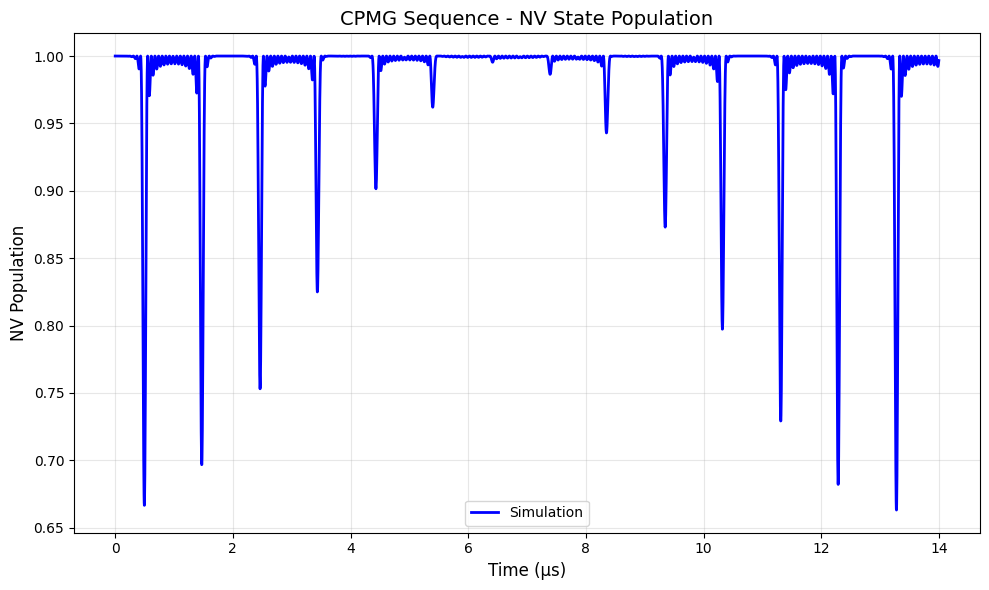

In [12]:
# Plot results
plt.figure(figsize=(10, 6))
t0 = t / 2
plt.plot(t0, Sa, 'b-', linewidth=2, label='Simulation')
plt.xlabel('Time (μs)', fontsize=12)
plt.ylabel('NV Population', fontsize=12)
plt.title('CPMG Sequence - NV State Population', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Find minimum (optimal tau)
min_idx = np.argmin(Sa)
min_val = Sa[min_idx]
tau = t[min_idx]

print(f"\nMinimum found at:")
print(f"  Index: {min_idx}")
print(f"  Value: {min_val:.6f}")
print(f"  Optimal tau: {tau:.6f} μs")


In [13]:
np.pi / (2* B*gammaN +Al)

0.5752058000071555

In [ ]:
# Finding pi/2 pulse for nuclear spin rotation
print("\nOptimizing nuclear spin gate...")
nn = 40
nn_r = 2*np.linspace(1, nn, nn)
irho = np.kron(irho_z, irho_MIX)

# Initialization
rho_0 = np.kron(U090xp, I) @ irho @ np.kron(U090xp, I).T.conj()

Sb = np.zeros(nn)
for h in range(nn):
    # Free evolution operators
    U_e2 = eigvecs @ expm(-1j*E*tau/2) @ U_H
    U_e = eigvecs @ expm(-1j*E*tau) @ U_H
    
    rho_1 = U_e2 @ rho_0 @ U_e2.T.conj()
    
    for k in range(2*h):
        rho_1 = (U_e @ np.kron(U180xp, I) @ rho_1 @ 
                 np.kron(U180xp, I).T.conj() @ U_e.T.conj())
    
    rho_2 = (U_e2 @ np.kron(U180xp, I) @ rho_1 @ 
             np.kron(U180xp, I).T.conj() @ U_e2.T.conj())
    rho_3 = np.kron(U090xmp, I) @ rho_2 @ np.kron(U090xmp, I).T.conj()
    
    Sb[h] = np.real(np.trace(irho_z @ PartialTrace(rho_3, 2)))

min_idx_sb = np.argmin(Sb)
min_val_sb = Sb[min_idx_sb]
b = min_idx_sb

if b % 2 == 0:  # if even
    b = b + 1
    tau = tau - tau / 3.268 / b

Ng = b  # number of pi pulses to generate pi/2 x gate
print(f"  Optimal Ng: {Ng}")
print(f"  Adjusted tau: {tau:.6f} μs")

# Generate nuclear spin gate
NU090 = NU0(Al, Ap, 1.386*2, 18)

# Test the gate
frho = (np.kron(U090xmp, I) @ NU090 @ np.kron(U090xp, I) @ irho @ 
        np.kron(U090xp, I).T.conj() @ NU090.T.conj() @ 
        np.kron(U090xmp, I).T.conj())
gate_fidelity = np.real(np.trace(irho_z @ PartialTrace(frho, 2)))
print(f"  Gate fidelity: {gate_fidelity:.6f}")

# Nuclear spin initialization
print("\nSimulating nuclear spin initialization...")
N_init = 100
T_init = 100
t_init = np.linspace(0, T_init, N_init)
t2 = np.linspace(0.8, 1.0, N_init)
t0_init = t2 * 2
irho = np.kron(irho_z, irho_MIX)

# Initialization sequence
rho_1 = np.kron(U090xp, I) @ irho @ np.kron(U090xp, I).T.conj()
rho_2 = NU090 @ rho_1 @ NU090.T.conj()

SN = np.zeros(N_init)
for k in range(N_init):
    rho_3 = NU0(Al, Ap, t0_init[k], 60) @ rho_2 @ NU0(Al, Ap, t0_init[k], 60).T.conj()
    rho_4 = NU090 @ rho_3 @ NU090.T.conj()
    rho_4 = np.kron(U090xp, I) @ rho_4 @ np.kron(U090xp, I).T.conj()
    SN[k] = np.real(np.trace(irho_z @ PartialTrace(rho_4, 2)))


In [ ]:
# Plot initialization results
plt.figure(figsize=(10, 6))
plt.plot(t2, SN, 'r-', linewidth=2)
plt.xlabel('Normalized Time', fontsize=12)
plt.ylabel('Initialization Fidelity', fontsize=12)
plt.title('Nuclear Spin Initialization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
